# Final Project

### 獲取歷史資料

In [1]:
from finlab.data import Data
from finlab_old.data import Data as data1
import pandas as pd
import sqlite3
import os
import numpy as np

conn = sqlite3.connect(os.path.join('data', 'data.db'))
pd = pd.read_sql('select * from legal_person',conn,index_col = ['date'])
## 上面沒有整理

data1 = data1()


data = Data()

big = data1.get('三大法人買賣超股數',10000000).fillna(0)
#big0 = data1.get('外陸資買賣超股數(不含外資自營商)',10000000).fillna(0)
#le0 = data1.get('外資買進股數',10000000).fillna(0)
#le1 = data1.get('投信買進股數',10000000).fillna(0)
#le3 = data1.get('三大法人買超股數',10000000).fillna(0)
#bigm = big.rolling(3).sum()
rev = data.get("當月營收")
close = data.get("收盤價")
pbe = data.get('股價淨值比')
pe = data.get('本益比')
rev.index = rev.index.shift(5, "d")
#total = big0+big



### 計算features

In [2]:
def legal(n):
    legal = big.rolling(n,min_periods=1).sum()
    #legal = legal.replace([np.inf, -np.inf], np.nan).fillna(0)
    return legal


def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

features = {
    'mom1': mom(1),
    'mom2': mom(2),
    'mom3': mom(3),
    'mom4': mom(4),
    'mom5': mom(5),
    'mom6': mom(6),
    'mom7': mom(7),
    'mom8': mom(8),
    'mom9': mom(9),
    
    'bias5': bias(5),
    'bias10': bias(10),
    'bias20': bias(20),
    'bias60': bias(60),
    'bias120': bias(120),
    'bias240': bias(240),
    
    'acc5': acc(5),
    'acc10': acc(10),
    'acc20': acc(20),
    'acc60': acc(60),
    'acc120': acc(120),
    'acc240': acc(240),
    
    
    'pe':pe,
    'pbe':pbe,
    
    

    
}
 #  'legal5':legal(5),
 #  'legal10':legal(10),
 #  'legal20':legal(20),
 #  'legal60':legal(60),
 #  'legal120':legal(120),
 #  'legal240':legal(240),
  #  'rsv5': rsv(5),
  #  'rsv10': rsv(10),
  #  'rsv20': rsv(20),
  #  'rsv60': rsv(60),
  #  'rsv120': rsv(120),
  #  'rsv240': rsv(240),
   # 'big1':big1,
   # 'big2':big2,
   # 'big3':big3,

### 製作dataset

##### 設定買賣頻率

In [3]:
every_month = rev.index
every_month

DatetimeIndex(['2005-02-15', '2005-03-15', '2005-04-15', '2005-05-15',
               '2005-06-15', '2005-07-15', '2005-08-15', '2005-09-15',
               '2005-10-15', '2005-11-15',
               ...
               '2019-04-15', '2019-05-15', '2019-06-15', '2019-07-15',
               '2019-08-15', '2019-09-15', '2019-10-15', '2019-11-15',
               '2019-12-15', '2020-02-15'],
              dtype='datetime64[ns]', name='date', length=180, freq=None)

##### 將dataframe 組裝起來

In [4]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [5]:

for name, f in features.items():
    features[name] = f.unstack()

In [6]:
import pandas as pd
dataset = pd.DataFrame(features)

In [7]:
feature_names = list(dataset.columns)

### 新增 label

In [8]:
from finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

In [9]:
import sklearn.preprocessing as preprocessing
dataset_scaled = pd.DataFrame(preprocessing.scale(dataset),index = dataset.index , columns = dataset.columns)
dataset_scaled["return"] = dataset["return"]
dataset_scaled["rank"] = dataset["rank"]
# 可以把其他東西放回來 除了以下這些
#dataset['pe'] = dataset['pe'].rank(pct=True)
#dataset['pbe'] = dataset['pbe'].rank(pct=True)
#dataset['legal5'] = dataset['legal5'].rank(pct=True)
#dataset['legal10'] = dataset['legal10'].rank(pct=True)
#dataset['legal20'] = dataset['legal20'].rank(pct=True)
#dataset['legal60'] = dataset['legal60'].rank(pct=True)
#dataset['legal120'] = dataset['legal120'].rank(pct=True)
#dataset['legal240'] = dataset['legal240'].rank(pct=True)
#dataset['big2'] = dataset['big2'].rank(pct=True)
#dataset['big3'] = dataset['big3'].rank(pct=True)

### 刪除太大太小的歷史資料

In [10]:
print(dataset.shape)

dataset = ml.drop_extreme_case(dataset_scaled, 
    ['bias60', 'bias120', 'bias240', 'mom1', 'mom2', 'mom3', 'mom4', 'mom5', 'mom6']
                               ,thresh=0.01)

print(dataset.shape)


(349920, 25)
(327440, 25)


In [11]:
dataset_dropna = dataset.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [12]:
dataset_train = dataset_dropna[:'2017']
dataset_test = dataset_dropna['2018':]

### 神經網路模型

In [13]:
import keras
from keras.initializers import he_normal
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dense(100, activation='relu',
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dropout(0.9))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1, )

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2400      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 12,601
Trainable params: 12,601
Non-trainable params: 0
_________________________________________________________________
start fitting
Instructions for updating:
Use tf.cast instead.
Train on 76894 sample

### 結果

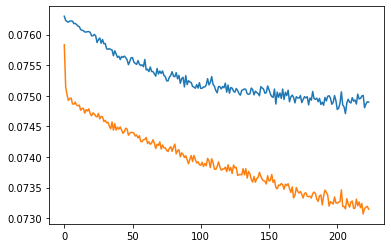

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

In [15]:
history.history['loss'][-1]

0.07314884017119189

## 開始表演

In [15]:
import keras
from keras.initializers import he_normal
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(100, activation='relu',
                      kernel_initializer=he_normal(seed=0)))

model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(100, activation='relu',
                      kernel_initializer=he_normal(seed=0)))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(100, activation='relu',
                      kernel_initializer=he_normal(seed=0)))

model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(loss='mean_squared_error',
              optimizer="adam",)

print('start fitting')
history = model.fit(dataset_train[feature_names], dataset_train['rank'],
                    batch_size=1000,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1, )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               2400      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
__________

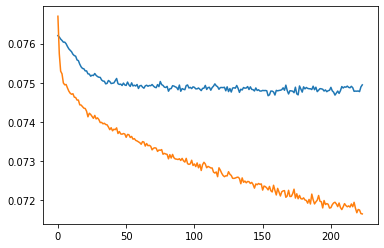

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['val_loss'][1:])
plt.plot(history.history['loss'][1:])

In [20]:
import math


dates = sorted(list(set(dataset_test.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_test.loc[d]
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates).cumprod()

s0050 = close['0050']['2018':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()

KeyError: 'result2'

In [ ]:
#原本1.27
rs[-1]

In [ ]:
rs,l = rs1(68,37,11)
rs = pd.Series(rs, index=dates)

s0050 = close['0050']['2018':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()

In [60]:
rs[-1]

1.4430871932250537

In [53]:
## 原本的1.46

## 結束表演

### lightgbm Model

In [21]:
import lightgbm as lgb
cf = lgb.LGBMRegressor(n_estimators=500)
cf.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Random Forest Model

In [22]:
from sklearn.ensemble import RandomForestRegressor

cf2 = RandomForestRegressor(n_estimators=100)
cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

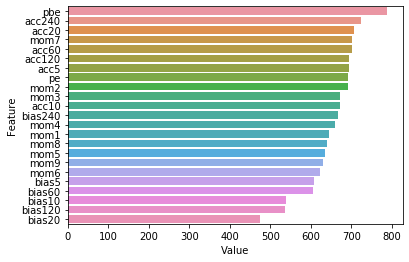

In [23]:
feature_imp = pd.DataFrame(zip(cf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [24]:
vals1 = model.predict(dataset_test[feature_names].astype(float))
dataset_test['result1'] = pd.Series(vals1.swapaxes(0,1)[0], dataset_test.index)

vals2 = cf.predict(dataset_test[feature_names].astype(float))
dataset_test['result2'] = pd.Series(vals2, dataset_test.index)

vals3 = cf2.predict(dataset_test[feature_names].astype(float))
dataset_test['result3'] = pd.Series(vals3, dataset_test.index)


C:\Users\Dandy\Anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Dandy\Anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Dandy\Anaconda3\envs\finlab\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

## 原本的

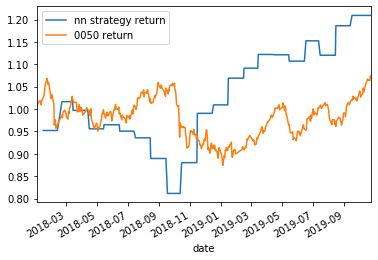

In [25]:
import math


dates = sorted(list(set(dataset_test.index)))

rs = []
for d in dates:
    
    dataset_time = dataset_test.loc[d]
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
    
    condition = (rank >= rank.nlargest(20).iloc[-1]) 
    r = dataset_time['return'][condition].mean()

    rs.append(r * (1-3/1000-1.425/1000*2*0.6))

rs = pd.Series(rs, index=dates).cumprod()

s0050 = close['0050']['2018':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()


In [26]:
rs[-1]

1.2093178938333875

In [23]:
def leg(n1,n3):
    condition1 = big.rolling(n1).sum() >n3*1000

In [24]:

## 組合學習評分策略

def rs(n1):
    dates = sorted(list(set(dataset_test.index)))
    rs = []
    for d in dates:
        
        dataset_time = dataset_test.loc[d]
        rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
            
        condition = (rank >= rank.nlargest(n1).iloc[-1]) 
        r = dataset_time['return'][condition].mean()
    
        rs.append(r * (1-3/1000-1.425/1000*2*0.6))
            
    rs = pd.Series(rs, index=dates).cumprod()
    return rs,condition

In [24]:
rmax = 0
for i in range(1,50,1):
    try:
        r,l = rs(i)
        rsn = r[-1]
        if rmax<rsn:
            rmax = rsn
            print(rmax,i)
    except:
        pass
    continue

0.7270564727357515 1
0.8744944157751036 2
1.1320001209890151 3
1.1537852768434411 4
1.2201622010837514 13
1.2251719957106773 16
1.2396634127582657 19
1.273394501100953 20
1.2866394921340105 21
1.2883362439937605 22
1.2907479733269396 23
1.2938198475980716 24
1.300015304578473 26
1.305775165163795 27


## 添加三大反人條件

In [27]:
def leg(n1,n3):
    condition1 = big.rolling(n1).sum() >n3*1000
    return condition1

In [28]:
#(外資+投信+自營商-外資借券).rolling(N1).sum()
#每月15號選出rank前(N2)的股票進行買入
# N1天內法人的增加張數要超過N3張

def rs1(n1,n2,n3):
    dates = sorted(list(set(dataset_test.index)))
    rs = []
    for d in dates:
        
        dataset_time = dataset_test.loc[d]
        rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
            
        condition = (rank >= rank.nlargest(n2).iloc[-1]) 
        #r = dataset_time['return'][condition].mean()
            # 開始蝦七八亂改
        rk = dataset_time[condition]['stock_id']
        rd = []
        for n in rk:
            rd.append(n)
    
    #condition1 = big.rolling(n1).sum() >n3*1000
        condition1 = leg(n1,n3)
        con = pd.DataFrame(condition1.unstack()[rd])
    #con1 = con.pivot_table(index="stock_id",columns="date")
        con0 = con.pivot_table(index="date",columns="stock_id")
        con01 = con0.reindex(every_month, method='ffill').dropna()
        con02 = con01.loc[d][0]
        con03 = con02[con02]
        con04=[]
        for i in con03.index:
            con04.append(i)
            
        test = dataset_time.reset_index().set_index("stock_id")
        lo = test["return"][con04].mean()
        #lo = lo.dropna()
        
         #結束蝦七八亂改
        rs.append(lo * (1-3/1000-1.425/1000*2*0.6))
            
    rs = pd.Series(rs, index=dates).cumprod()
    return rs,con04

In [70]:
#(外資+投信+自營商-外資借券).rolling(N1).sum()
#每月15號選出rank前(N2)的股票進行買入
# N1天內法人的增加張數要超過N3張
rmax = 0
for i in range(60,100,1):
    try:
        r,c = rs1(i,37,11)
        rsn = r[-1]
        if rmax<rsn:
            rmax = rsn
        print(rmax,i)
    except:
        pass
    continue

1.5034458458971012 60
1.5100136095204602 61
1.5283832066695737 62
1.5283832066695737 63
1.5283832066695737 64
1.5283832066695737 65
1.5283832066695737 66
1.5283832066695737 67
1.5283832066695737 68
1.538467758637416 69
1.538467758637416 70
1.538467758637416 71
1.538467758637416 72
1.538467758637416 73
1.538467758637416 74
1.538467758637416 75
1.538467758637416 76
1.538467758637416 77
1.538467758637416 78
1.538467758637416 79
1.538467758637416 80
1.538467758637416 81
1.538467758637416 82
1.538467758637416 83
1.538467758637416 84
1.538467758637416 85
1.538467758637416 86
1.538467758637416 87
1.538467758637416 88
1.538467758637416 89
1.538467758637416 90
1.538467758637416 91
1.538467758637416 92
1.538467758637416 93
1.538467758637416 94
1.538467758637416 95
1.538467758637416 96
1.538467758637416 97
1.538467758637416 98
1.538467758637416 99


In [37]:
n3=11 =>1.2023
n2=37 =>1.31354
n1 1  1.3799
1.5006838816849806 59
1.5283832066695737 68

SyntaxError: invalid syntax (<ipython-input-37-df1efbff1962>, line 1)

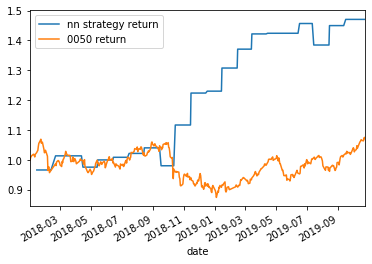

In [29]:
rs,l = rs1(68,37,11)
rs = pd.Series(rs, index=dates)

s0050 = close['0050']['2018':]

pd.DataFrame({'nn strategy return':rs.reindex(s0050.index, method='ffill'), '0050 return':s0050/s0050[0]}).plot()

In [30]:
rs

2018-01-15    0.966008
2018-02-15    1.013340
2018-03-15    1.013312
2018-04-15    0.975481
2018-05-15    0.999677
2018-06-15    1.008487
2018-07-15    1.021491
2018-08-15    1.040063
2018-09-15    0.980119
2018-10-15    1.116591
2018-11-15    1.223567
2018-12-15    1.229964
2019-01-15    1.307367
2019-02-15    1.370596
2019-03-15    1.421605
2019-04-15    1.423766
2019-05-15    1.423822
2019-06-15    1.456477
2019-07-15    1.384440
2019-08-15    1.449458
2019-09-15    1.470256
dtype: float64

In [ ]:
#for i in range(1,10,1):
#    for j in range(1,10,1):
#        for k in range(1,10,1):
#            try:
#                rmax = 0
#                r,c = rs1(i,j,k)
#                r = r[-1]
#                if rmax<r:
#                    print(rmax,i,j,k)
#            except:
#                pass
#            continue
#慢慢來 會出事


In [39]:
rmax = 0
for j in range(5,10,1):
    try:
        r,c = rs1(5,27,j)
        rsn = r[-1]
        if rmax<r[-1]:
            rmax = r
            print(rmax,k)
    except:
        pass
    continue

In [46]:
dates = sorted(list(set(dataset_test.index)))
rs = []
for d in dates:
        
    dataset_time = dataset_test.loc[d]
    rank = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] 
            
    condition = (rank >= rank.nlargest(300).iloc[-1]) 
    #r = dataset_time['return'][condition].mean()
        # 開始蝦七八亂改
    rk = dataset_time[condition]['stock_id']
    rd = []
    for n in rk:
        rd.append(n)
    
    #condition1 = big.rolling(n1).sum() >n3*1000
    condition1 = leg(5,5)
    con = pd.DataFrame(condition1.unstack()[rd])
    #con1 = con.pivot_table(index="stock_id",columns="date")
    con0 = con.pivot_table(index="date",columns="stock_id")
    con01 = con0.reindex(every_month, method='ffill').dropna()
    con02 = con01.loc[d][0]
    con03 = con02[con02]
    con04=[]
    for i in con03.index:
        con04.append(i)
            
    test = dataset_time.reset_index().set_index("stock_id")
    lo = test["return"][con04].mean()
        #lo = lo.dropna()
        
         #結束蝦七八亂改
    rs.append(lo * (1-3/1000-1.425/1000*2*0.6))
            
rs = pd.Series(rs, index=dates).cumprod()

In [61]:
rank.nlargest(300)

date
2019-06-15    1.905331
2019-06-15    1.891801
2019-06-15    1.887364
2019-06-15    1.871696
2019-06-15    1.843316
2019-06-15    1.819814
2019-06-15    1.809436
2019-06-15    1.806249
2019-06-15    1.802532
2019-06-15    1.791400
2019-06-15    1.784046
2019-06-15    1.783763
2019-06-15    1.782530
2019-06-15    1.779363
2019-06-15    1.775036
2019-06-15    1.769852
2019-06-15    1.769284
2019-06-15    1.768046
2019-06-15    1.765795
2019-06-15    1.764251
2019-06-15    1.763984
2019-06-15    1.763937
2019-06-15    1.762073
2019-06-15    1.761108
2019-06-15    1.759738
2019-06-15    1.758563
2019-06-15    1.757963
2019-06-15    1.756679
2019-06-15    1.756515
2019-06-15    1.755744
                ...   
2019-06-15    1.615145
2019-06-15    1.615120
2019-06-15    1.614631
2019-06-15    1.614540
2019-06-15    1.613614
2019-06-15    1.613503
2019-06-15    1.613364
2019-06-15    1.612893
2019-06-15    1.612693
2019-06-15    1.612492
2019-06-15    1.612225
2019-06-15    1.612145
2019-0

In [67]:
rd

['1101',
 '1102',
 '1201',
 '1465',
 '1514',
 '2404',
 '2414',
 '2812',
 '2849',
 '2851',
 '2904',
 '3226',
 '4722',
 '5245',
 '6218',
 '6221',
 '6486',
 '6508',
 '8446',
 '9943']

In [25]:
r,c = rs1(5,20,17)
r[-1]

1.1677012067321708

In [23]:
r[-1]

1.070964464258957

### 當月持股狀況

stock_id  date      
1201      2019-08-15    1.505489
1434      2019-08-15    1.535945
1707      2019-08-15    1.406626
2206      2019-08-15    1.502443
2236      2019-08-15    1.473526
2404      2019-08-15    1.489815
2812      2019-08-15    1.598333
2832      2019-08-15    1.662192
2845      2019-08-15    1.690368
2849      2019-08-15    1.498570
2891      2019-08-15    1.452448
4722      2019-08-15    1.516161
5706      2019-08-15    1.450519
6189      2019-08-15    1.508385
8081      2019-08-15    1.399126
8481      2019-08-15    1.552472
9911      2019-08-15    1.667698
dtype: float64

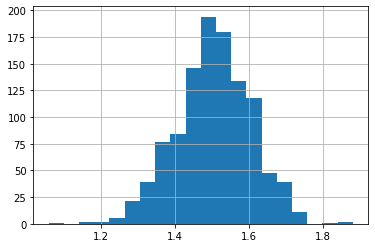

In [87]:
# get the latest dataset

last_date = dataset.index.levels[1].max()
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


# remove NaN testcases

#print("Some stocks are skipped due to NaN")
#print(last_dataset[last_dataset[feature_names].isnull().sum(axis=1) != 0].index.get_level_values("stock_id").values)
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = cf.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = cf2.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
condition = (rank >= rank.nlargest(20).iloc[-1]) 

# plot rank distribution
rank.hist(bins=20)


# show the best 20 stocks


stock_id  date      
1533      2019-08-15    1.740019
1540      2019-08-15    1.713157
1541      2019-08-15    1.756575
1762      2019-08-15    1.882149
2107      2019-08-15    1.722287
2377      2019-08-15    1.722419
2643      2019-08-15    1.714698
2834      2019-08-15    1.750045
2851      2019-08-15    1.713711
2904      2019-08-15    1.742230
3005      2019-08-15    1.747282
3702      2019-08-15    1.718035
4402      2019-08-15    1.708829
5215      2019-08-15    1.708671
5289      2019-08-15    1.727369
5291      2019-08-15    1.728467
5493      2019-08-15    1.720125
6023      2019-08-15    1.716572
6289      2019-08-15    1.862858
8420      2019-08-15    1.818211
dtype: float64

In [ ]:
from finlab_old.data import Data
data = Data()
big = data.get('三大法人買賣超股數',10000000)

big = big.fillna(0)
bigm = big.rolling(3).sum()
condition1 = (big - bigm)>3*1000

big.reindex(every_month, method='ffill').unstack()
big = pd.DataFrame(big)
big = big.dropna(how='any')
big = big.reset_index().set_index("date")

## 小結論

In [ ]:
con = pd.DataFrame(condition1.unstack()[rd])
con1 = con.pivot_table(index="stock_id",columns="date")
con0 = con.pivot_table(index="date",columns="stock_id")
con1 = con1[0]
con2 = con1["2012-05-25"]

test = dataset_time.reset_index().set_index("stock_id")
test["return"][rd]
con3 = con2[con2].index
con4 = []
for i in con3:
    con4.append(i)
#con4

#test["return"][con4]#.mean()  #成功選出我們所需要的股票

In [ ]:
con01 = con0.reindex(every_month, method='ffill').dropna()
con02 = con01.loc[d][0]
con03 = con02[con02]

con04=[]
for i in con03.index:
    con04.append(i)
if con04!=[]:
    lo = test["return"][con04]
    print(lo)

In [ ]:
import datetime
from finlab.crawler import date_range
#condition1.unstack()[rd]
d= condition1.unstack()[rd].reset_index().set_index("date")
#d = d['2012-05-10']
#d.reindex(every_month, method='ffill')
#new_m = every_month[87:]
#d.reindex(new_m, method='ffill')
new_m = date_range(datetime.date(2012,5,10),datetime.date(2019,8,3))
d.columns
